# Необходимые ссылки:

- https://gitlab.com/Nanopro/TecWrap - ссылка на свежую версию моей библиотеки TecWrap
- https://github.com/Nanopro/tecwrap_guide - ссылка на эту демонстрацию со всеми файлами, которые могут понадобиться при установке

# 1. Установка

Предварительные настройки:
- Добавить в \$PATH путь до ESI\2014.0\UTILS\bin (если планируется автоматическая конвертация .dtf файлов);
- Создать переменную $TEC360_PATH содержащую путь до директории инсталяции TecPlot360/bin
- переместить файл startTecUtilServer.mcr (см. папку install) в TecPlot360/bin

Оффлайн установка:
1. скачать flatbuffers-2015.12.22.1-py2.py3-none-any (см. папку install), перейти в папку с этим файлом, выполнить комманду в bash/cmd/Anaconda promt "pip install flatbuffers-2015.12.22.1-py2.py3-none-any"
2. перейти в директорию установки Tecplot 360 EX 2018 R1/pytecplot, выполнить в bash/cmd/Anaconda promt "pip install ."
3. скачать tecwrap.py в дирректорию, в которой находятся ваши .py/.ipynb файлы, с которыми ведете работу

Онлайн установка:
1. выполнить pip install pytecplot
2. скачать tecwrap.py в дирректорию, в которой находятся ваши .py/.ipynb файлы, с которыми ведете работу

# 2. Использование библиотеки TecWrap

Импорт необходимых библиотек:

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from tecwrap import TecWrapper, TecSession
import numpy as np


Опционально для создание графиков:

In [25]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib inline

Устанавливаем соединение с TecPlot, в качестве аргумента указываем директорию с файлами которые будем обрабатывать (опционально):

In [26]:
wrap = TecWrapper(r'C:\Users\Maxim\tecwrap_guide')

Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.


Произойдет запуск Tecplot и подключение скрипта к нему. В случае успеха появится сообщение Connection established.

Для того чтобы открыть файл и производить в нём какие либо действия, используется протокол менеджера контекста:

In [27]:
with wrap('3dkepsnotur.tec') as ses:
    ses.show_contour('W')

C:\Users\Maxim\tecwrap_guide\3dkepsnotur.tec


В окне TecPlot произойдет открытие файла, в котором уже будут произведены все указанные манипуляции.

<img src="images/tube.jpg">

В качестве аргумента принимаются:
- путь до файла расширения .dtf, .tec относительно рабочей директории, которая была указана в аргументах TecWrapper
- полный путь до файла

## Реализованные функции:

Объемный срез плоскость через все активные зоны:

In [28]:
with wrap('3dkepsnotur.tec') as ses:
    X, Y, W, P_otot = ses.volume_slices(
        origins = [
        (0,0,z) for z in [0, 0.33 -1e-14, 0.66-1e-14, 1-1e-14]
    ], 
        normal = (0,0,1),
        values = ('X', 'Y', 'W', 'P_tot'),
    )
    ses.show_contour('W')

C:\Users\Maxim\tecwrap_guide\3dkepsnotur.tec


Пример окна TecPlotпосле выполнения команды выше:

<img src="images/zslices.jpg">

# Warning!

По неизвестной никому причине, слайсы, плоскости которых совпадают с линиями сетки ведут себя непредсказуемо! Поэтому к координате каждого сечения лучше прибавлять или отнимать очень маленькое число (например 1e-14, меньше не работает).

In [29]:
print(type(W), W.shape)

<class 'numpy.ndarray'> (4, 500)


In [31]:
xi, yi = np.meshgrid(
    np.linspace(X[2].min(), X[2].max(), 1000),
    np.linspace(Y[2].min(), Y[2].max(), 1000),             
)
zi = griddata((X[2], Y[2]), W[2],(xi, yi), method='linear')

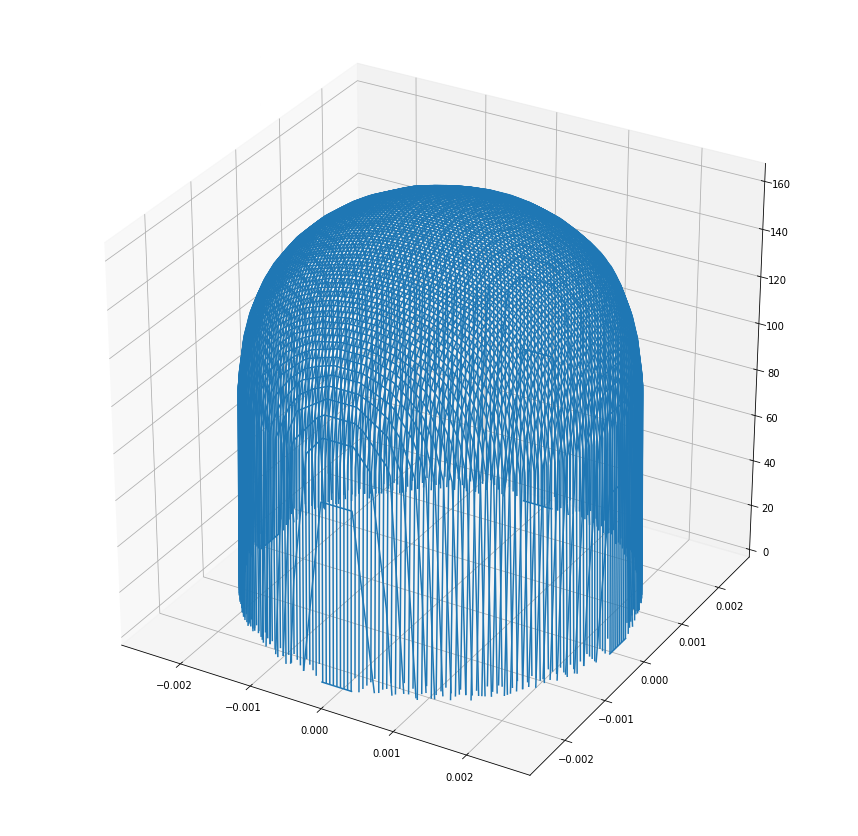

In [32]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(xi, yi, zi, rstride=10, cstride=10)

plt.show()


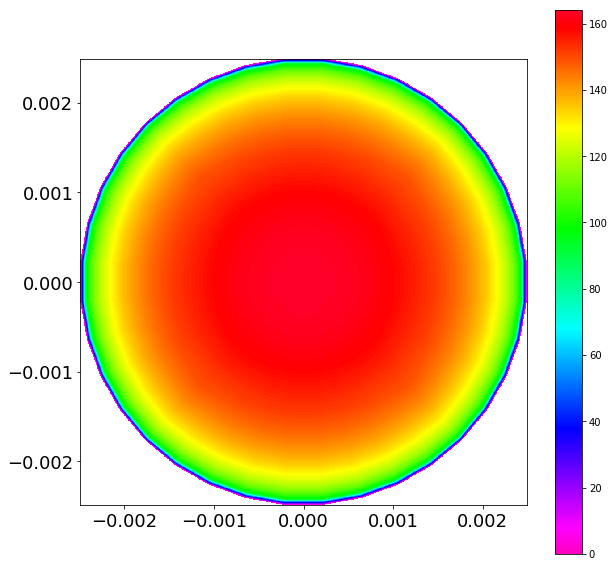

In [33]:
plt.figure(figsize = (10,10))
plt.imshow(zi, cmap = 'gist_rainbow_r', extent=(xi.min(),xi.max(),yi.min(),yi.max()))
plt.tick_params(labelsize = 18)
plt.colorbar()
plt.show()

Имеется ряд alias-ов для упрощения, например:
- volume_x_slices - объемный разрез плоскостями, параллельными плоскости YZ.
- get_z_slice - автоматический разрез плоскостью, параллельной плоскости XY.

In [34]:
with wrap('3dkepsnotur.tec') as ses:
    Y,Z,P_tot = ses.get_x_slice(cord = 0, values = ('Y', 'Z', 'P_tot'))

C:\Users\Maxim\tecwrap_guide\3dkepsnotur.tec


In [39]:
xi, yi = np.meshgrid(
    np.linspace(Z.min(), Z.max(), 1000),
    np.linspace(Y.min(), Y.max(), 1000),             
)
zi = griddata((Z, Y), P_tot,(xi, yi), method='cubic')

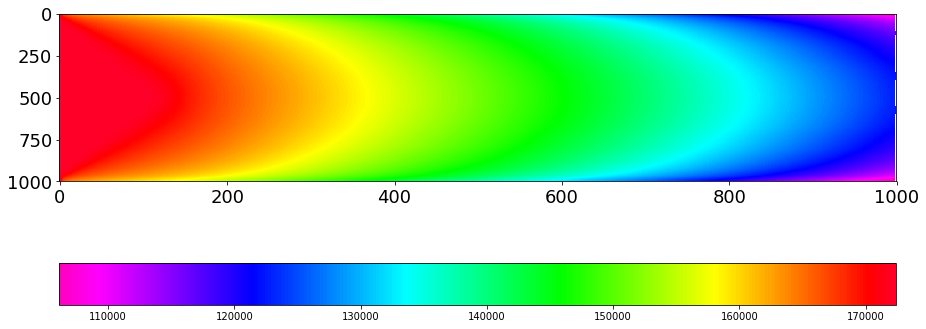

In [40]:
fig = plt.figure(figsize = (15,10))
plt.imshow(zi, cmap = 'gist_rainbow_r')
plt.colorbar(orientation = 'horizontal')
plt.gca().set_aspect(1/5)
plt.tick_params(labelsize = 18)
plt.show()

Поверхностный срез имеет ту же сигнатуру, что и объемный, применяется для 2D моделей. 

In [ ]:
with wrap('2dkepsnotur.dtf') as ses:
    X,Y, W, P_tot = ses.surface_slices(
        origins = [
        (0,0,z) for z in [0, 0.33 -1e-14, 0.66-1e-14, 1-1e-14]
    ], 
        normal = (0,0,1),
        values = ('X', 'Y', 'W', 'P_tot'),
    )

Имеется функция для снятия данных по линии (задается пересечением двух плоскостей):

In [41]:
Z = [0, 0.33 -1e-14, 0.66-1e-14, 1-1e-14]
with wrap('3dkepsnotur.tec') as ses:
    Y, W = ses.surfaces_intersection(
        surface_1=[(0,0,0), (1,0,0)],
        surfaces = [
            [(0,0,z), (0,0,1)] for z in Z
        ],
        values = ('Y', 'W')
    )

C:\Users\Maxim\tecwrap_guide\3dkepsnotur.tec


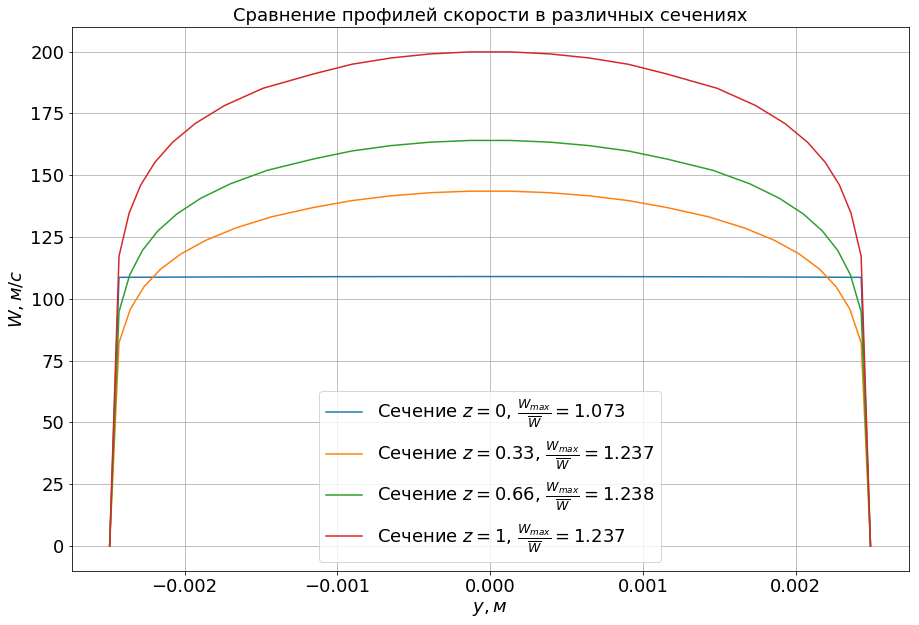

In [42]:
plt.figure(figsize = (15,10))
for y,w,z in zip(Y,W,Z): 
    umaxavg = w.max()/w.mean()
    plt.plot(np.sort(y),w[y.argsort()], label = r'Сечение '+ f'$z = {z:.4g}$'+  r', $\frac{W_{max}}{\overline{W}} ='+'{:.4g}'.format(umaxavg)+'$' )
    plt.title(f'Сравнение профилей скорости в различных сечениях', fontdict = {'fontsize': 18})
    plt.tick_params(labelsize = 18)
    plt.xlabel('$y, м$', fontdict = {'fontsize': 18})
    plt.ylabel('$W, м/с$', fontdict = {'fontsize': 18})
    plt.grid(True)
    plt.legend(fontsize = 18)

In [43]:
with wrap('3dkepsnotur.tec') as ses:
    Z, W = ses.surface_intersection(
        surface_1 = [(0,0,0), (1,0,0)],
        surface_2 = [(0,0,0), (0,1,0)],
        values = ('Z', 'W')
    )

C:\Users\Maxim\tecwrap_guide\3dkepsnotur.tec


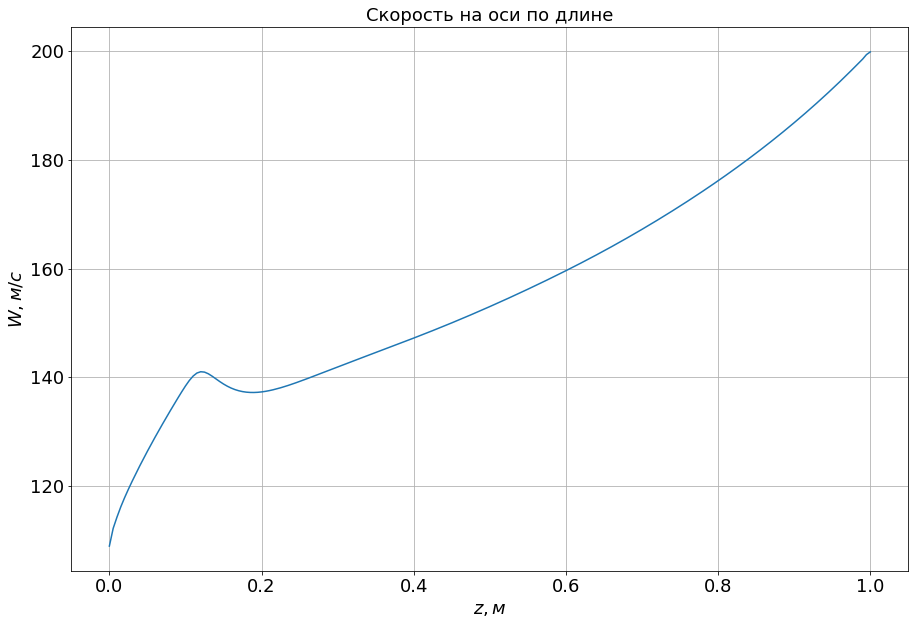

In [44]:
plt.figure(figsize = (15,10))
plt.plot(Z,W)
plt.title('Скорость на оси по длине', fontdict = {'fontsize': 18})
plt.tick_params(labelsize = 18)
plt.xlabel('$z, м$', fontdict = {'fontsize': 18})
plt.ylabel('$W, м/с$', fontdict = {'fontsize': 18})
plt.grid(True)

Также имеется возможность изъять все значения из всех активных зон:

In [45]:
with wrap('3dkepsnotur.tec') as ses:
    X, Y, Z = ses.get_values(values = ('X', 'Y', 'Z'))

C:\Users\Maxim\tecwrap_guide\3dkepsnotur.tec


In [47]:
Z.shape

(1, 20100)

# Использование pytecplot напрямую.

Я использовал библиотеку pytecplot следующим образом:

- Импорты:

In [48]:
import tecplot as tp, tecplot
import numpy as np
import os
import subprocess
import functools
import psutil

Запускаем TecPlot360 руками, после запуска ставим галочку в:

<img src = "images/con1.png">
<img src = "images/con2.png">

Устанавливаем соединение:

In [49]:
tp.session.connect(timeout=20)

Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.


Если соединение установлено успешно, выведется сообщение: Connection established.

Открываем нужный файл, руками в TecPlot, либо следующей строкой (результат выполнения сохраняем в переменную dataset):

In [50]:
dataset = tp.data.load_tecplot('C:/users/Maxim/tecwrap_guide/3dkepsnotur.tec', read_data_option=tp.constant.ReadDataOption.ReplaceInActiveFrame)

------------------------------
### Опционально:


Для того чтобы экспортировать файл из формата .dtf в формат .tec, можно воспользоваться следующей командой:

In [51]:
file = 'C:/users/Maxim/tecwrap_guide/3dkepsnotur.dtf'
os.system(r'dtf_to_tec.exe {input} {out} 1'.format(input=file, out=file[:-3] + 'tec'))

0

В случае успеха, мы получим код 0.


---------------------------------------------------

Для того чтобы работать с 2D геометрией как с 3D, создадим новую переменную Z_NULL равной 0, синтаксис совпадаем с equations в самом TecPlot:

In [52]:
tp.data.operate.execute_equation(equation='{Z_NULL}=0')

Для того чтобы изменить тип графика в активном окне, сохраним ссылку на график, и изменимим его аттребут:

In [53]:
frame = tp.active_frame()
frame.plot_type = tp.constant.PlotType.Cartesian3D

Задать какие переменные будут использоваться в качестве осей для графика, можно следующим образом:

In [ ]:
frame.plot().axes.z_axis.variable = dataset.variable('Z')

Для того чтобы извлечь данные слайсом:

In [54]:
extracted_slice = tp.data.extract.extract_slice(
            origin=(0,0,1), #точка
            normal=(0,0,0.5-1e-14), #нормаль
            source=tp.constant.SliceSource.VolumeZones, #тип слайса
            dataset=dataset) #датасет

Для того чтобы извлечь нужные переменные и сохранить их в np.array:

In [55]:
P = extracted_slice.values('P_tot').as_numpy_array()

In [56]:
P

array([120136.85156233, 120923.99999965, 121359.70312422, 121652.74999917,
       121652.74999917, 120136.85156265, 121359.70312461, 120136.8515625 ,
       120136.85156233, 120136.85156233, 120136.8515625 , 120136.85156265,
       120924.        , 121141.8515625 , 121359.703125  , 121723.11979167,
       121652.75      , 121751.171875  , 121652.75000054, 121652.75000013,
       121652.75      , 122140.35625   , 121359.703125  , 121359.70312524,
       120924.        , 120136.8515625 , 120136.85156265, 122661.71093732,
       122395.40885417, 121359.70312524, 121359.703125  , 121359.70312461,
       121555.06770833, 122461.984375  , 122351.1796875 , 122661.7109375 ,
       122661.71093759, 122661.71093759, 122661.7109375 , 122661.71093732,
       122120.2421875 , 122440.1015625 , 122440.1015625 , 122859.3359375 ,
       122962.80078125, 123066.265625  , 122928.3125    , 123066.265625  ,
       122859.3359375 , 122859.33593731, 122859.3359375 , 122440.1015625 ,
       121726.56640625, 1

Получить список переменных:

In [57]:
[var.name for var in dataset.variables()]

['X',
 'Y',
 'Z',
 'RHO',
 'U',
 'V',
 'W',
 'VelocityMagnitude',
 'Mach',
 'P',
 'P_tot',
 'Vislam',
 'T',
 'T_TOT',
 'H0',
 'COND_TURB',
 'CP',
 'COND_eff',
 'D',
 'K',
 'Z_NULL']

Список активных зон:

In [58]:
[var.name for var in frame.active_zones()]

['Simple zone 1',
 'Simple zone 2',
 'Simple zone 3',
 'Simple zone 4',
 'Simple zone 5',
 'Slice: Z=1']

Изменить список активных зон:

In [59]:
frame.active_zones([frame.active_zones()[-1]])

([Zone(uid=42, dataset=Dataset(uid=11, frame=Frame(uid=2, page=Page(uid=1))))],)

Активировать все зоны:

In [60]:
frame.active_zones(dataset.zones())

(<generator object Dataset.zones at 0x0000022EAEF3F888>,)

Также можно напрямую исполнять макросы:

In [61]:
tp.macro.execute_extended_command(command_processor_id='CFDAnalyzer4',
    command="""SetFluidProperties 
    Incompressible='F' 
    Density=1 
    SpecificHeat=2.5 
    UseSpecificHeatVar='F' 
    SpecificHeatVar=1 
    GasConstant=287
    UseGasConstantVar='F' 
    GasConstantVar=1 
    Gamma=1.41 
    UseGammaVar='F' 
    GammaVar=1 
    Viscosity=1 
    UseViscosityVar='F' 
    ViscosityVar=1 
    Conductivity=1 
    UseConductivityVar='F' 
    ConductivityVar=1
    """)